In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from ast import literal_eval
import pingouin as pg
from statsmodels.stats.weightstats import ztest

import pingouin as pg
%matplotlib inline

In [2]:
# Общая настройка графиков
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

# Часть 1. Исследование данных.

In [3]:
# Читаю данные
users_test = pd.read_csv('data/Проект_3_users_test.csv', sep=';')
users_control_1 = pd.read_csv('data/Проект_3_users_control_1.csv', sep=';')
users_control_2 = pd.read_csv('data/Проект_3_users_control_2.csv', sep=';')
transactions_test = pd.read_csv('data/Проект_3_transactions_test.csv', sep=';')
transactions_control_1 = pd.read_csv('data/Проект_3_transactions_control_1.csv', sep=';')
transactions_control_2 = pd.read_csv('data/Проект_3_transactions_control_2.csv', sep=';')

In [4]:
print(f"В датафрейме users_test {users_test.shape[0]} строк")
print(f"В датафрейме users_control_1 {users_control_1.shape[0]} строк")
print(f"В датафрейме users_control_2 {users_control_2.shape[0]} строк")
print(f"В датафрейме transactions_test {transactions_test.shape[0]} строк")
print(f"В датафрейме transactions_control_1 {transactions_control_1.shape[0]} строк")
print(f"В датафрейме transactions_control_2 {transactions_control_2.shape[0]} строк")

В датафрейме users_test 4308 строк
В датафрейме users_control_1 4340 строк
В датафрейме users_control_2 4264 строк
В датафрейме transactions_test 273 строк
В датафрейме transactions_control_1 1007 строк
В датафрейме transactions_control_2 328 строк


In [5]:
users_test.isnull().sum()

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64

In [6]:
users_control_1.isnull().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4280
country                0
visit_days          1324
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3904
is_premium          4148
total_revenue          0
dtype: int64

In [7]:
users_control_2.isnull().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4203
country                0
visit_days          1364
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3853
is_premium          4073
total_revenue          0
dtype: int64

В таблицах с юзерами не наблюдаю аномалий. Много пропусков в coins, т.к не у всех пользователей есть внутренняя валюта, пропуски в visit_days, т.к не все пользователи хоть раз использовали приложение, пропуски в was/is premium, т.к не все покупают подписку.

In [8]:
transactions_test.isnull().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [9]:
transactions_control_1.isnull().sum()

uid             630
country         630
joined_at         0
paid_at           0
revenue         630
payment_id      630
from_page       630
product_type    630
dtype: int64

In [10]:
transactions_control_2.isnull().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

В таблице transactions_control_1 явно что-то сломалось, дропну пустые значения. В остальных таблицах пропуски отсутствуют.

In [11]:
transactions_control_1 = transactions_control_1.dropna()

In [12]:
# Подготавливаю данные с пользователями
users_control_2['Group'] = 'control_2'
users_control_1['Group'] = 'control_1'
users_test['Group'] = 'test'

users_control = pd.concat([users_control_1, users_control_2])
users = pd.concat([users_control, users_test])

# Подготавливаю данные с транзакциями
transactions_test['group'] = 'test'
transactions_control_1['group'] = 'control_1'
transactions_control_2['group'] = 'control_2'

transactions_control = pd.concat([transactions_control_1, transactions_control_2])
transactions = pd.concat([transactions_test, transactions_control_1, transactions_control_2])


Поскольку изменения цены произошло не во всех странах, а только в некоторых, то начать изучение хотелось бы именно с них.

In [13]:
print(f"В контрольных группах пользователей {users_control.country.nunique()} стран \n")
print(users_control.country.unique())
print(f"\n В тестовой группе пользователей {users_test.country.nunique()} стран \n")
print(users_test.country.unique())
print("\n")
print(f"В контрольных группах транзакций {transactions_control.country.nunique()} стран \n")
print(transactions_control.country.unique())
print(f"\n В тестовой группе транзакций {transactions_test.country.nunique()} стран \n")
print(transactions_test.country.unique())

В контрольных группах пользователей 58 стран 

['United States of America' 'France' 'Argentina' 'Chile' 'Italy'
 'Australia' 'Germany' 'Spain' 'Israel' 'United Kingdom (Great Britain)'
 'United Arab Emirates' 'Belgium' 'Portugal' 'Canada' 'Switzerland'
 'Russian Federation' 'India' 'Egypt' 'Venezuela' 'Puerto Rico' 'Algeria'
 'Costa Rica' 'Ukraine' 'Mexico' 'Tunisia' 'Colombia' 'Sweden' 'Turkey'
 'Panama' 'Romania' 'China' 'Armenia' 'Dominican Republic' 'Kyrgyzstan'
 'Peru' 'Moldova, Republic of' 'Jamaica' 'Philippines' 'Burkina Faso'
 'Qatar' 'Pakistan' 'Austria' 'Morocco' 'Uruguay' 'Georgia' 'Hungary'
 'New Zealand' 'Malaysia' 'Mali' 'Nicaragua' 'Belarus' 'Czech Republic'
 'Uganda' 'Tajikistan' 'Kuwait' 'Somalia' 'Paraguay' 'Lithuania']

 В тестовой группе пользователей 51 стран 

['United States of America' 'Germany' 'Israel' 'France' 'Spain'
 'Australia' 'Italy' 'Argentina' 'Belgium' 'Azerbaijan' 'Chile' 'Portugal'
 'United Kingdom (Great Britain)' 'United Arab Emirates' 'Morocco'


Можно заметить, что в тестовой группе меньше стран, чем в контрольной. Самое интересное, что в таблицах с транзакциями стран примерно в 2 раза меньше. Теперь хотелось бы посмотреть одни и те же ли пользователи в таблицах. Если нет, то можно предположить, что в таблицах есть какие-то ошибки. 

In [14]:
transactions_test.shape[0]

273

In [15]:
transactions_test.merge(users_test, how = 'left', on = 'uid').shape[0]

273

In [16]:
transactions_control.shape[0]

705

In [17]:
transactions_control.merge(users_control, how = 'left', on = 'uid').shape[0]

705

Пользователи внутри таблиц являются одинаковыми, однако в данных по юзерам гораздо больше строк. Делаю предположение, что большинство клиентов являются не платящими, поэтому и многие страны отсутствуют в таблицах с транзакциями.

In [18]:
transactions_test.query("revenue == 0")

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group


In [19]:
transactions_control.query("revenue == 0")

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group


Да, в таблицах с транзакциями отсутствуют какие-либо операции с 0 доходом. 

Для начала отфильтрую наши данные по странам. Возьму только страны, которые есть в тестовой и в контрольных группах транзакций, анализировать буду по ним. 

In [20]:
# Передаю переменным все страны из таблиц с транзакциями тестовой и контрольных групп
test_country = list(transactions_test.country.unique())
control_country = list(transactions_control.country.unique())

# Передаю в переменную пересечение стран, этот список буду использовать для фильтрации
country_filter = list(set(test_country) & set(control_country))


# Фильтрую данные с пользователями
users_control_2 = users_control_2.query("country in @country_filter")
users_control_1 = users_control_1.query("country in @country_filter")
users_test = users_test.query("country in @country_filter")

users_control = pd.concat([users_control_1, users_control_2])
users = pd.concat([users_control, users_test])

# Фильтрую данные с транзакциями
transactions_test = transactions_test.query("country in @country_filter")
transactions_control_1  = transactions_control_1.query("country in @country_filter")
transactions_control_2  = transactions_control_2.query("country in @country_filter")

transactions_control = pd.concat([transactions_control_1, transactions_control_2])
transactions = pd.concat([transactions_test, transactions_control_1, transactions_control_2])

In [21]:
country_groupped = users_control.groupby(['country', 'Group'], as_index=False) \
    .agg(count=('uid', 'count'))

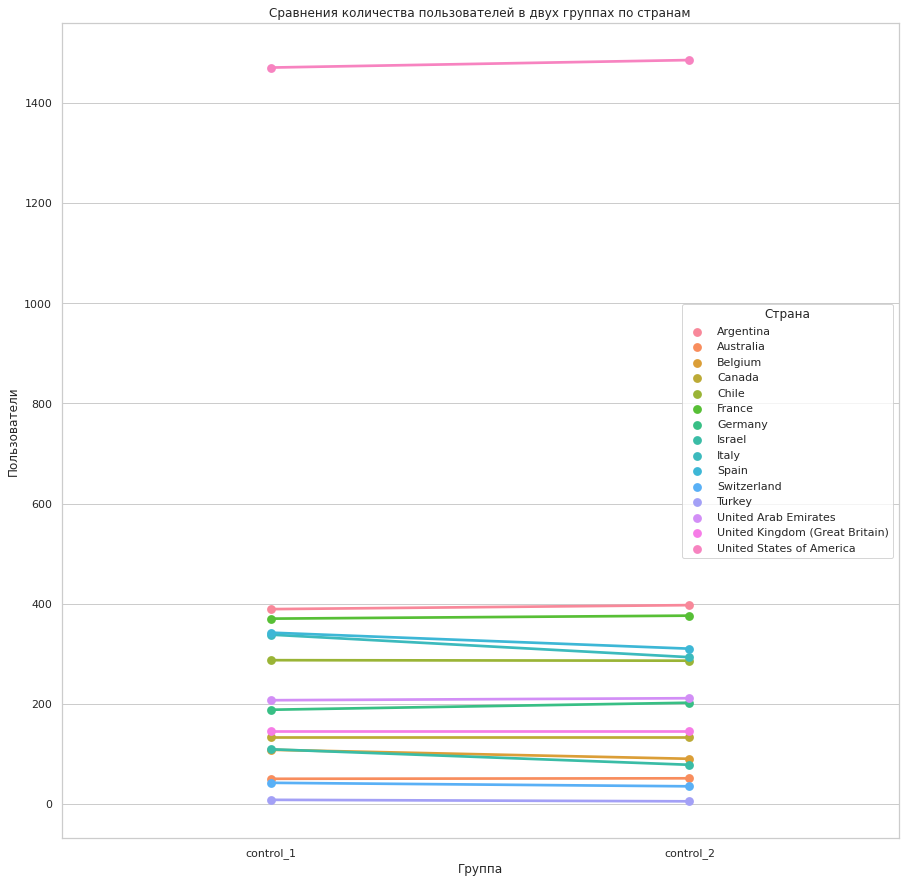

In [22]:
plt.figure(figsize=(15, 15))
sns.pointplot(data=country_groupped, x='Group', y='count', hue='country')
plt.title('Сравнения количества пользователей в двух группах по странам')
plt.ylabel('Пользователи')
plt.xlabel('Группа')
plt.legend(title='Страна')

Визуально сплитование по странам отработало корректно. Можно отметить, что в нашем эксперименте наибольшее количество пользователей из США, а наименьшее из Турции. Проверю также статистически при помощи таблицы сопряженности.

In [23]:
country_cross = pd.crosstab(users_control.country, users_control.Group)

In [24]:
res = chi2_contingency(country_cross[['control_1', 'control_2']])
print(f"p-value: {res[1]}")

p-value: 0.551229604440158


H0 - Нет статистически значимой связи между группами пользователей и страной.

H1 - Существует статистически значимая связь между группами пользователей и страной.

P-value > 0.05 => не можем отклонить нулевую гипотезу, которая гласит, что нет статистически значимой связи между группами пользователей и страной. Делаю вывод, что в данном кейсе сплитование по странам отработало корректно.

Вслед за исследованием стран хотелось бы рассмотреть подробнее временной промежуток. 

In [25]:
print(f"""Самая ранняя регистрация в тестовой группе: {transactions_test.joined_at.min()} 
Крайняя регистрация в тестовой группе: {transactions_test.joined_at.max()}

Самая ранняя регистрация в контрольной группе: {transactions_control.joined_at.min()} 
Крайняя регистрация в контрольной группе: {transactions_control.joined_at.max()}

Самая ранняя транзакция в тестовой группе: {transactions_test.paid_at.min()} 
Крайняя транзакция в тестовой группе: {transactions_test.paid_at.max()}

Самая ранняя транзакция в контрольной группе: {transactions_control.paid_at.min()} 
Крайняя транзакция в контрольной группе: {transactions_control.paid_at.max()}
""")

Самая ранняя регистрация в тестовой группе: 2017-01-11 03:07:00 
Крайняя регистрация в тестовой группе: 2017-10-31 23:40:00

Самая ранняя регистрация в контрольной группе: 2017-01-11 01:06:00 
Крайняя регистрация в контрольной группе: 2017-10-31 22:17:00

Самая ранняя транзакция в тестовой группе: 2017-01-11 04:37:00 
Крайняя транзакция в тестовой группе: 2017-12-11 22:06:00

Самая ранняя транзакция в контрольной группе: 2017-01-11 02:56:00 
Крайняя транзакция в контрольной группе: 2017-12-11 23:28:00



Можно заметить, что даты в тестовой и контрольной группе совпадают. В данном случае проблем с дизайном эксперимента мною не выявлено. Можно предположить, что тест длился с 2017-01-11 по 2017-12-11 (очень долго). 

Проверю нет ли неточности в датах транзакций. 

In [26]:
pay_time = transactions.groupby(['uid', 'paid_at'], as_index = False) \
            .agg(trans_count = ('product_type', 'count')) \
            .sort_values('trans_count', ascending = False)
pay_time.query("trans_count > 1").head()

,uid,paid_at,trans_count
789,892333905.0,2017-10-16 02:08:00,5
178,891367521.0,2017-06-11 17:43:00,4
735,892236423.0,2017-10-22 22:08:00,4
180,891367521.0,2017-10-11 01:52:00,4
737,892236423.0,2017-10-23 00:14:00,3


Обратил внимание, что у некоторых пользователей есть несколько транзакций в одно и то же время. Рассмотрю данные случаи немного подробнее.


In [27]:
udis = list(pay_time.query("trans_count > 1").uid.unique())
paid_time = list(pay_time.query("trans_count > 1").paid_at.unique())

transactions.query("uid in @udis and paid_at in @paid_time").sort_values('uid')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
143,891178380.0,Spain,2017-08-11 03:54:00,2017-11-14 04:33:00,12610.0,19.0,empty_likes,coins,test
106,891178380.0,Spain,2017-08-11 03:54:00,2017-11-14 04:33:00,3783.0,67.0,empty_likes,other_type,test
61,891208638.0,Israel,2017-07-11 15:43:00,2017-08-11 19:01:00,871.0,19.0,empty_likes,coins,control_2
83,891208638.0,Israel,2017-07-11 15:43:00,2017-08-11 19:01:00,871.0,146.0,empty_likes,coins,control_2
138,891216033.0,United States of America,2017-07-11 12:33:00,2017-07-11 12:47:00,6292.0,0.0,autoreply_message,premium_no_trial,control_1
...,...,...,...,...,...,...,...,...,...
304,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 02:26:00,31525.0,19.0,menu,coins,control_1
57,892339626.0,United States of America,2017-10-15 23:21:00,2017-10-20 18:14:00,754.0,19.0,empty_likes,coins,test
243,892339626.0,United States of America,2017-10-15 23:21:00,2017-10-20 18:14:00,754.0,19.0,empty_likes,coins,test
99,892435536.0,United States of America,2017-10-14 02:54:00,2017-10-14 16:50:00,897.0,146.0,empty_likes,coins,control_2


В целом, это выглядит подозрительно. Однако данные с точностью до минут, а не секунд, поэтому трудно утверждать что-то конкретно, поскольку сделать несколько операций за минуту более чем реально. 

Вопрос с точностью времени можно записать в проблему проведения эксперимента.

Также рассмотрю никто ли не попал одновременно в 2 группы.

In [28]:
# Передаю переменным все страны из таблиц с транзакциями тестовой и контрольных групп
test_users = list(transactions_test.uid.unique())
control_users= list(transactions_control.uid.unique())

# Передаю в переменную пересечение стран, этот список буду использовать для фильтрации
users_filter = list(set(test_users) & set(control_users))
print(f"Количество пользователей, которые попали сразу в 2 группы (transactions): {len(users_filter)}")

# Передаю переменным все страны из таблиц с транзакциями тестовой и контрольных групп
test_users = list(users_test.uid.unique())
control_users= list(users_control.uid.unique())

# Передаю в переменную пересечение стран, этот список буду использовать для фильтрации
users_filter = list(set(test_users) & set(control_users))
print(f"Количество пользователей, которые попали сразу в 2 группы (users): {len(users_filter)}")

Количество пользователей, которые попали сразу в 2 группы (transactions): 0
Количество пользователей, которые попали сразу в 2 группы (users): 0


В данном случае система сплитования отработала корректно и никакой пользователь не попал одновременно в 2 группы. 

Цена за подписку изменилась в нескольких странах для двух платежных систем. Нужно посмотреть на данные и найти колонку с платежной системой. 

In [29]:
transactions.head(1)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891345942.0,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,test


In [30]:
transactions.payment_id.unique()

array([147.,  67.,  19., 146.,  68.,   0., 127.])

В таблице с транзакциями всего есть колонка payment_id с 7 уникальными идентификаторами. Могу предположить, что именно в этом поле находятся наши платежные системы. Изучу его немного подробнее. 

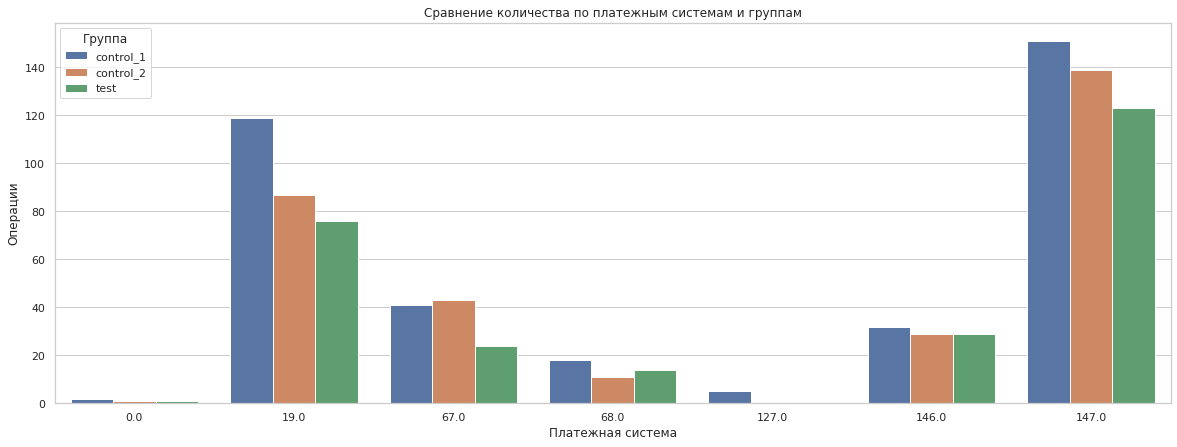

In [31]:
payment_id = transactions.groupby(['group', 'payment_id'], as_index = False) \
            .agg(count_payment_id = ('uid', 'count'))

sns.barplot(data = payment_id, x = 'payment_id', y = 'count_payment_id', hue = 'group')
plt.title('Сравнение количества по платежным системам и группам')
plt.ylabel('Операции')
plt.xlabel('Платежная система')
plt.legend(title='Группа')

Рассмотрев график количества операций по разным платежным системам можно заметить, что больше всего операций с платежной системы 147 и платежной системы 19, а меньше всего с 0. На данном графике рассмотрены все категории, визуализирую более детально только по подпискам.  

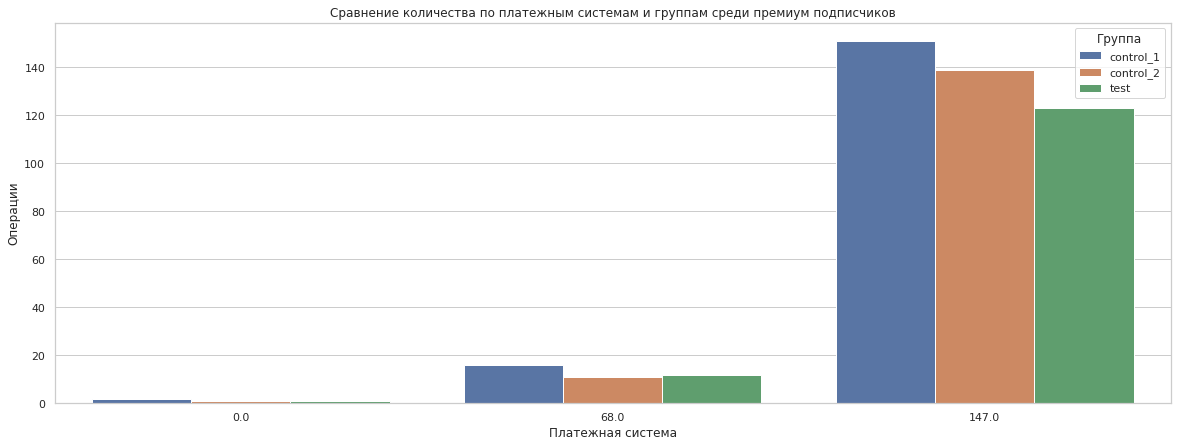

In [32]:
# premium_no_trial буду также учитывать, т.к это потенциальные премиум подписчики. 
payment_id = transactions.query("product_type in ('trial_premium', 'premium_no_trial')") \
            .groupby(['group', 'payment_id'], as_index = False) \
            .agg(count_payment_id = ('uid', 'count'))

sns.barplot(data = payment_id, x = 'payment_id', y = 'count_payment_id', hue = 'group')
plt.title('Сравнение количества по платежным системам и группам среди премиум подписчиков')
plt.ylabel('Операции')
plt.xlabel('Платежная система')
plt.legend(title='Группа')

Можно заметить, что премиум подписчики используют не все платежные системы в нашем эксперименте. Нельзя достоверно отметить в каких из трех платежных системах произошли изменения, однако могу предположить, что в 147 и 0 (т.к ею пользуются довольно редко, возможно захотели увеличить количество пользователей). Посмотрю также на средний чек по платежной система и группе.

In [33]:
payment_id = transactions.groupby(['group', 'payment_id'], as_index = False) \
            .agg(AOV = ('revenue', 'mean'))

payment_pivot = pd.pivot(data = payment_id,
         index = 'payment_id',
         columns = 'group',
         values = 'AOV'
        ).reset_index()
payment_pivot = payment_pivot.style.set_caption("Свод AOV по группе и платежной системе")
payment_pivot

group,payment_id,control_1,control_2,test
0,0.000000,6357.000000,4719.000000,9217.000000
1,19.000000,6309.042017,3277.793103,6677.210526
2,67.000000,3338.780488,2959.465116,3059.333333
3,68.000000,4466.222222,5728.272727,6869.571429
4,127.000000,1458.600000,nan,nan
5,146.000000,3732.218750,3311.413793,3593.379310
6,147.000000,9767.907285,9040.517986,12504.837398


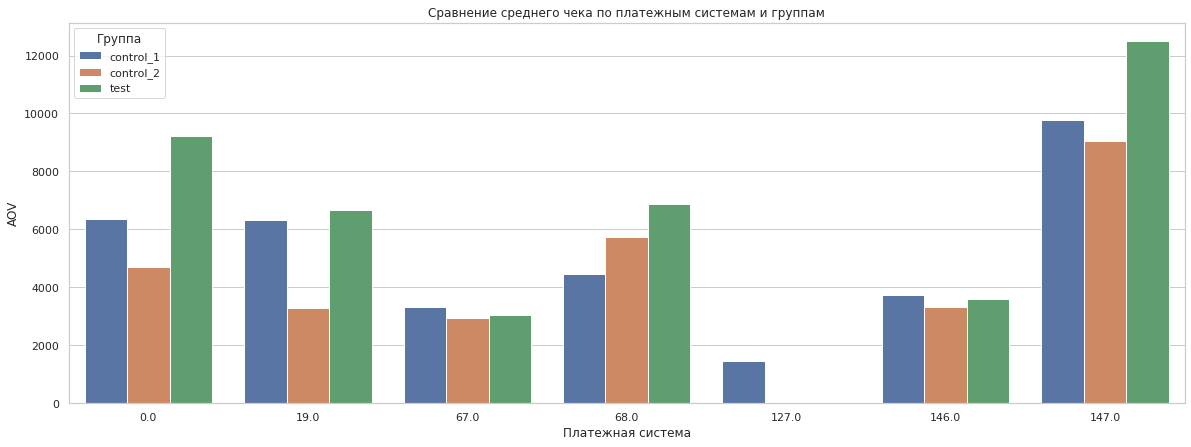

In [34]:
sns.barplot(data = payment_id, x = 'payment_id', y = 'AOV', hue = 'group')
plt.title('Сравнение среднего чека по платежным системам и группам')
plt.ylabel('AOV')
plt.xlabel('Платежная система')
plt.legend(title='Группа')

Возможно в эксперименте действительно участвует платежная система 0, т.к несмотря на малое количество транзакций она показывает хороший средний чек. Однако достоверно утверждать нельзя по этой информации, это всего лишь моя гипотеза.

Построю такой же график, но для операций с подписками. 

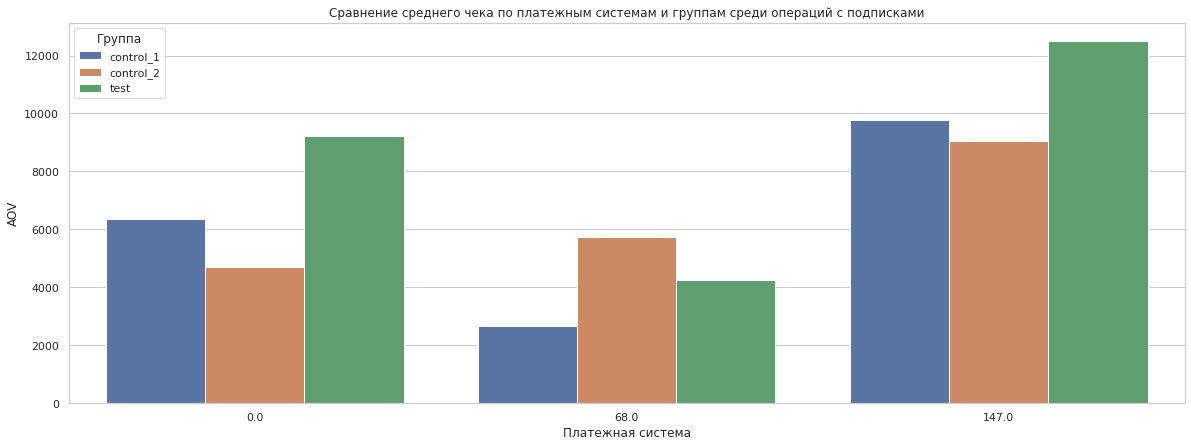

In [35]:
payment_id = transactions.query("product_type in ('trial_premium', 'premium_no_trial')") \
            .groupby(['group', 'payment_id'], as_index = False) \
            .agg(AOV = ('revenue', 'mean'))

sns.barplot(data = payment_id, x = 'payment_id', y = 'AOV', hue = 'group')
plt.title('Сравнение среднего чека по платежным системам и группам среди операций с подписками')
plt.ylabel('AOV')
plt.xlabel('Платежная система')
plt.legend(title='Группа')

Тут 0 платежная система также показывает неплохой средний чек, поэтому моя гипотеза остается прежней. 

Теперь хочу посмотреть на выручку по группам. Буду рассматривать по транзакциям с подпиской, т.к это именно та категория, на которую распространяется изменение

Text(0.5, 0, 'Группа')

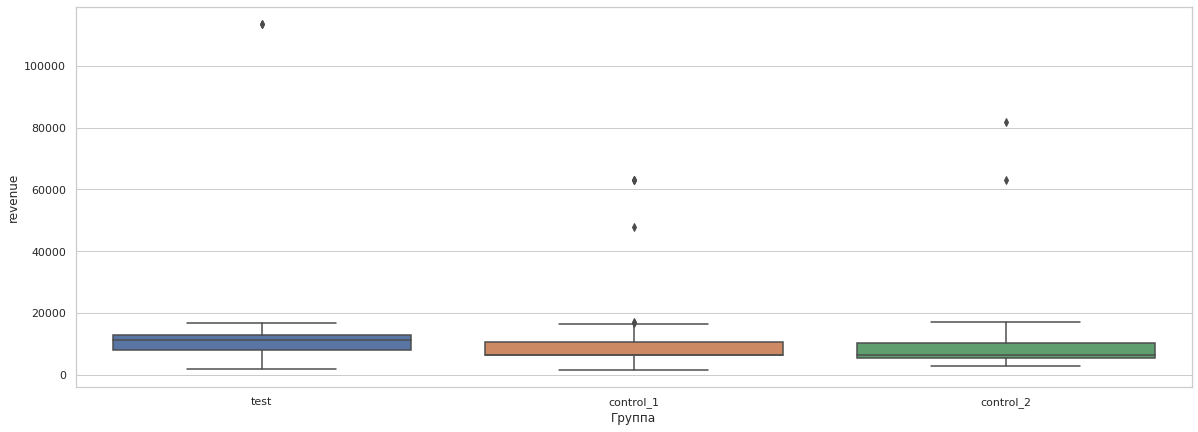

In [36]:
prem_transaction = transactions.query("product_type in ('trial_premium', 'premium_no_trial')")
sns.boxplot(data=prem_transaction, x='group', y='revenue')
plt.xlabel('Группа')

Медианный revenue по подпискам находится на уровне 10000 - 15000. Можно заметить, что есть выбросы и распределение скошено в правую сторону. Это довольно типичный паттерн для выручки. Попытаюсь разобраться с чем связаны сильные выбросы. Предполагаю, что это может зависеть от страны, поскольку на графике видна группа транзакций, а не одна, рассмотрю подробнее.

In [37]:
country_transactions = transactions.query("product_type in ('trial_premium', 'premium_no_trial')") \
                                   .groupby(['group', 'country'], as_index = False) \
                                   .agg(aov = ('revenue', 'mean')) \
                                   .sort_values('aov', ascending = False)
pd.pivot(data = country_transactions,
         index = 'country',
         columns = 'group',
         values = 'aov').reset_index()

group,country,control_1,control_2,test
0,Argentina,8936.416667,7957.444444,10530.000000
1,Australia,8495.500000,7548.666667,12597.000000
2,Belgium,11407.500000,10635.444444,12740.000000
3,Canada,7785.375000,8731.666667,7843.333333
4,Chile,8753.875000,7538.555556,8181.333333
5,France,7610.777778,8840.928571,12067.466667
6,Germany,5053.750000,9913.800000,10495.333333
7,Israel,7393.750000,8697.000000,13660.400000
8,Italy,8915.562500,9245.166667,8012.333333
9,Spain,9459.125000,11927.000000,18213.000000


Предполагаю, что есть ошибка в первой контрольной группе в Турции, посмотрю подробнее.

In [38]:
transactions \
    .query("product_type in ('trial_premium', 'premium_no_trial') and country == 'Turkey' and group == 'control_1'")

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
57,892344951.0,Turkey,2017-10-15 21:37:00,2017-10-15 21:40:00,3614.0,147.0,autoreply_message,premium_no_trial,control_1
317,891383310.0,Turkey,2017-04-11 20:47:00,2017-04-11 22:17:00,63037.0,147.0,autoreply_message,premium_no_trial,control_1
337,891693753.0,Turkey,2017-10-29 15:24:00,2017-06-11 22:30:00,3432.0,147.0,promo_09,premium_no_trial,control_1


Вижу одну большую транзакцию, посмотрю на другие операции с большой выручкой. 

In [39]:
transactions.query("revenue > 40000")

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
12,891178380.0,Spain,2017-08-11 03:54:00,2017-09-11 21:53:00,113477.0,147.0,promo_09,premium_no_trial,test
64,892275462.0,France,2017-10-17 05:56:00,2017-02-11 18:24:00,44083.0,19.0,coins_popup,other_type,test
196,892038759.0,United Arab Emirates,2017-10-22 11:12:00,2017-10-22 16:23:00,113477.0,147.0,autoreply_message,premium_no_trial,test
30,892421277.0,United States of America,2017-10-14 13:05:00,2017-10-15 13:11:00,47723.0,147.0,promo_09,premium_no_trial,control_1
143,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 13:10:00,63037.0,147.0,no_sympathy,premium_no_trial,control_1
277,892216461.0,United States of America,2017-10-18 14:41:00,2017-10-18 15:02:00,63037.0,147.0,autoreply_message,premium_no_trial,control_1
317,891383310.0,Turkey,2017-04-11 20:47:00,2017-04-11 22:17:00,63037.0,147.0,autoreply_message,premium_no_trial,control_1
22,892307238.0,Spain,2017-10-16 16:01:00,2017-10-16 20:41:00,63037.0,147.0,left_sidebar_menu,premium_no_trial,control_2
47,891778551.0,United Arab Emirates,2017-10-27 21:26:00,2017-10-27 22:30:00,81796.0,147.0,left_sidebar_menu,premium_no_trial,control_2


In [40]:
top_revenue_ids = list(transactions.query("revenue > 40000").uid) 
users.query("uid in @top_revenue_ids") # Посмотрю юзеров с большой выручкой

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,Group
284,892421277,22,446,62.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,16,35,130,1.0,1.0,60333,control_1
874,891383310,22,1000,NaN,Turkey,1,1,19,83,4,1.0,1.0,63037,control_1
1427,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,control_1
2296,892216461,19,293,6.0,United States of America,"1,2,3,5,8,9,11,13,15,16,17,18,19,20,22,23,24,2...",1,16,25,58,1.0,1.0,64298,control_1
1216,892307238,29,543,43.0,Spain,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,16,36,46,1.0,1.0,75647,control_2
1360,891778551,30,290,NaN,United Arab Emirates,"1,6,7,8,9,10",1,27,33,31,1.0,1.0,81796,control_2
992,892038759,26,323,3.0,United Arab Emirates,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,23,48,232,1.0,1.0,123565,test
2070,892275462,31,310,NaN,France,"1,2,3,4,5,9,13,15,16",1,36,68,58,1.0,1.0,14885,test
3629,891178380,42,275,85.0,Spain,"1,2,4,5,6,7",1,26,36,287,1.0,1.0,129870,test


Почти все операции с большой выручкой относятся к premium_no_trial. Если рассмотреть этих пользователей более подробно, то можно обратить внимание на то, что многие из них довольно активны. В целом, я могу предположить, что эти операции относятся к покупке премиума на длительный срок, поэтому не буду считать их выбросами и удалять. 

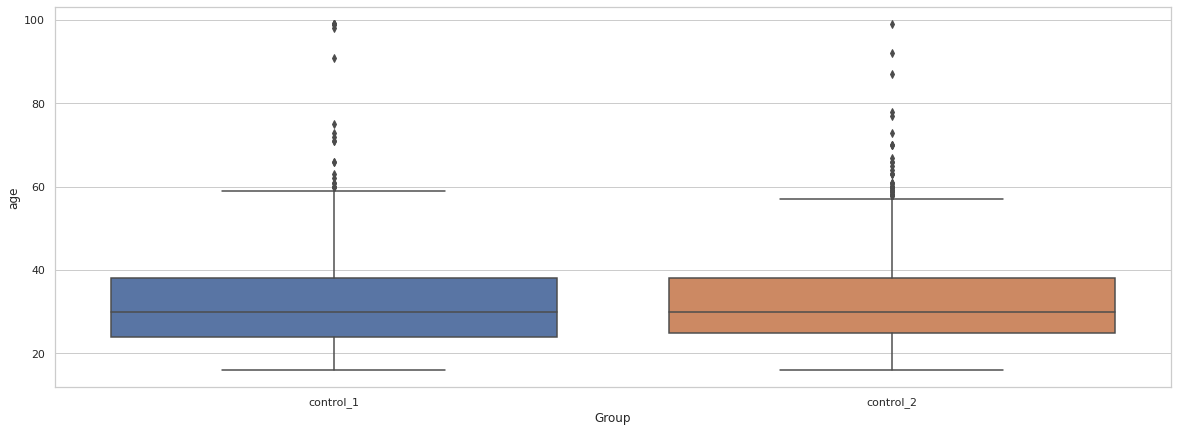

In [41]:
sns.boxplot(data=users_control, x='Group', y='age')

Кажется, что сплитование по возрасту отработало корректно. Средний возраст наших пользователей около 30 лет, но есть и явные выбросы, возраст некоторых приближается к сотне, нужно взглянуть на них подробнее.


In [42]:
users_control.query("age > 80")

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,Group
773,891746646,99,300,NaN,Italy,NaN,1,50,70,10,NaN,NaN,0,control_1
1466,891918399,99,62,NaN,Italy,"1,2,3",1,50,99,16,NaN,NaN,0,control_1
1856,891374112,99,900,NaN,United Arab Emirates,"1,2,3,4,5,6,7,8,9,10,11",1,16,99,462,NaN,NaN,0,control_1
2103,892185039,99,759,NaN,United Kingdom (Great Britain),"1,2,3,4,5,6,7,8,9",1,43,49,79,1.0,1.0,7332,control_1
2238,892321845,99,500,NaN,United States of America,NaN,1,22,99,4,NaN,NaN,0,control_1
2312,891682545,99,0,NaN,United States of America,NaN,1,96,102,0,NaN,NaN,0,control_1
2836,891900387,99,333,NaN,Italy,"1,3,4",1,16,99,3,NaN,NaN,0,control_1
2908,892335240,98,593,NaN,United States of America,1,1,22,28,32,NaN,NaN,0,control_1
3399,892278777,91,384,NaN,United Arab Emirates,1,1,16,23,13,NaN,NaN,0,control_1
137,892224798,92,320,NaN,United States of America,"1,2,4,5,6,7,10,12,15",1,21,28,50,NaN,NaN,0,control_2


Не нашел выявил ничего, что могло бы указать на возможную ошибку в данных. Однако у некоторых пожилых пользователей довольно забавные возрастные ограничения поиска.


In [43]:
gender_split = users_control.groupby(['gender', 'Group'], as_index=False) \
                            .agg(count=('uid', 'count'))

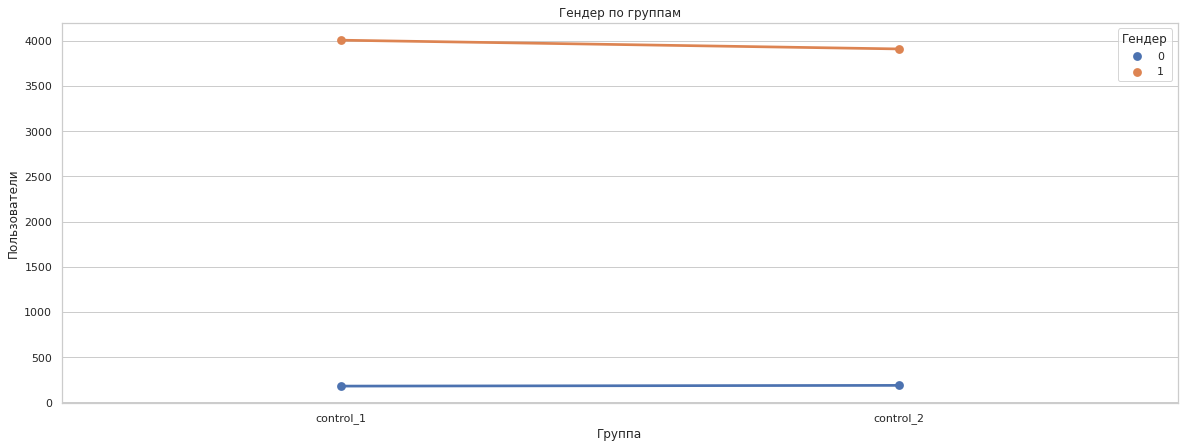

In [44]:
sns.pointplot(data=gender_split, x='Group', y='count', hue='gender')
plt.title('Гендер по группам')
plt.ylabel('Пользователи')
plt.xlabel('Группа')
plt.legend(title='Гендер')

Система сплитования по полу тоже разделила примерно одинаково в двух контрольных группах. Гендера 1 кратно больше, можно предположить, что 0 - женщины, а 1 - мужчины. Ради интереса посчитаю соотношение по полу и группе.


In [45]:
gender_ratio = pd.pivot(gender_split, index = 'Group', columns = 'gender', values = 'count') \
    .reset_index() \
    .rename(columns = {0 : 'female', 1: 'male'})
gender_ratio['ratio'] = round(gender_ratio.male / gender_ratio.female)
gender_ratio = gender_ratio.style.set_caption("Соотношение мужчин и женщин")
gender_ratio

gender,Group,female,male,ratio
0,control_1,180,4009,22.000000
1,control_2,188,3912,21.000000


Получается довольно интересная ситуация, в которой на каждую женщину приходится 21 - 22 мужчины. 

Теперь перейду к изучению коэффициента привлекательности, сравню их в контрольных группах для определени равенства выборок. 

H0 – в генеральной совокупности никакого различия между средними значениями в привлекательности пользователей нет.
H1 – средние коэффициента привлекательности в генеральной совокупности не равны.

In [46]:
attraction_split = users_control.groupby('Group', as_index=False) \
                                .agg({'attraction_coeff': 'mean'})
attraction_split = attraction_split.style.set_caption("Коэффициент привлекательности в контрольных группах")
attraction_split

,Group,attraction_coeff
0,control_1,313.275961
1,control_2,318.115610


Привлекательность пользователей в двух контрольных группах примерна одинакова и коэффициент составляет в среднем 314,5. Поскольку привлекательность все же отличается, то нужно проверить есть ли стат. значимое различие между группами. 

Для применения т-критерия Стьюдента дисперсии внутри групп должны быть примерно одинаковы, проверю это при помощи критерия Левена и перейду к сравнению.

Поскольку у нас есть информация только о дате регистрации платящих пользователей, то будем считать новыми только их, остальных исключаю из выборки.

In [47]:
ids = list(transactions_control.uid.unique())

stats.levene(users_control.query("Group == 'control_1' and uid in @ids").attraction_coeff, users.query(
    "Group == 'control_2' and uid in @ids").attraction_coeff)

LeveneResult(statistic=3.4383789184183726, pvalue=0.06450680268431268)

H0 – в генеральной совокупности никакого различия между дисперсиями контрольных групп нет.
H1 – дисперсии контрольных групп не равны в генеральной совокупности.

p-value > 0.05 => у нас нет оснований отклонить нулевую гипотезу о том, что в генеральной совокупности никакого различия между дисперсиями контрольных групп нет. Можно переходить к применению т-критери Стьюдента.

In [48]:
stats.ttest_ind(users_control.query("Group == 'control_1' and uid in @ids").attraction_coeff,
                users_control.query("Group == 'control_2' and uid in @ids").attraction_coeff)

Ttest_indResult(statistic=-1.7508880307360233, pvalue=0.08080756384012322)

p-value > 0.05, в нашем эксперименте привлекательность пользователей в двух контрольных группах стат. значимо не различается, у нас нет оснований отклонить нулевую гипотезу.

Теперь посмотрю на то, как разделили премиум пользователей 

In [49]:
was_prem_split = users.groupby('Group', as_index=False) \
                              .agg({'was_premium': 'count'})

is_prem_split = users.groupby('Group', as_index=False) \
    .agg({'is_premium': 'count'})

was_prem_split.merge(is_prem_split, how = 'left', on = 'Group')


,Group,was_premium,is_premium
0,control_1,425,186
1,control_2,397,182
2,test,398,154


Подписчиков примерно в 2 раза меньше, чем людей, которые были премиумами, можно соделать вывод, что меньшая часть пользователей выбирает продолжать подписку.


Теперь перейду к A/A/B тестированию. Буду считать следующие метрики:
    
1. AOV в категориях 'trial_premium' и 'premium_no_trial' среди новых пользователей (новыми пользователями буду считать тех, кто зарегистрировался в промежутке проведения эксперимента, т.е всех из таблицы transactions). Ожидаю, что для успешности эксперимента, AOV в тестовой группе должен быть стат. значимо больше;
2. конверсия в подписчика. Ожидаю, что среди в тестовой группе конверсия должна стат.значимо повыситься для увспешности эксперимента;
3. retention среди новых пользователей. Прокси метрика от которой ожидаю стат. значимое повышение в тестовой группе. Моя гипотеза заключается в том, что изменение цены должно привести к повышения конверсии, а платные пользователи пользуются и возвращаются в приложение чаще обычных;
4. количество пользователей в платежных системах 0, 68, 147. Ожидаю, что их количество должно стат. значимо различаться, поскольку изменение, предположительно, произошло в двух из этих систем.

Также хотелось бы отметить, что сравнения буду проводить по отобранным ранее странам.  

Retention буду рассчитывать по 7 дню, т.к в сфере знакомств пользователи часто принимают решения в течение первых нескольких дней. 7 дней предоставляют достаточно времени для того, чтобы пользователи оценили, насколько приложение соответствует их ожиданиям.

# Часть 2. A/A/B тестирование. 

Начну с расчета AOV в категориях 'trial_premium' и 'premium_no_trial' среди новых пользователей. 

In [50]:
# Беру датасет, в котором только 'trial_premium' и 'premium_no_trial', а также нужные нам страны 
# P.S страны были отфильтрованы еще на этапе исследования данных.
aov_df = transactions.query("product_type in ('trial_premium', 'premium_no_trial')")

Text(0.5, 0, 'Выручка с тразакции')

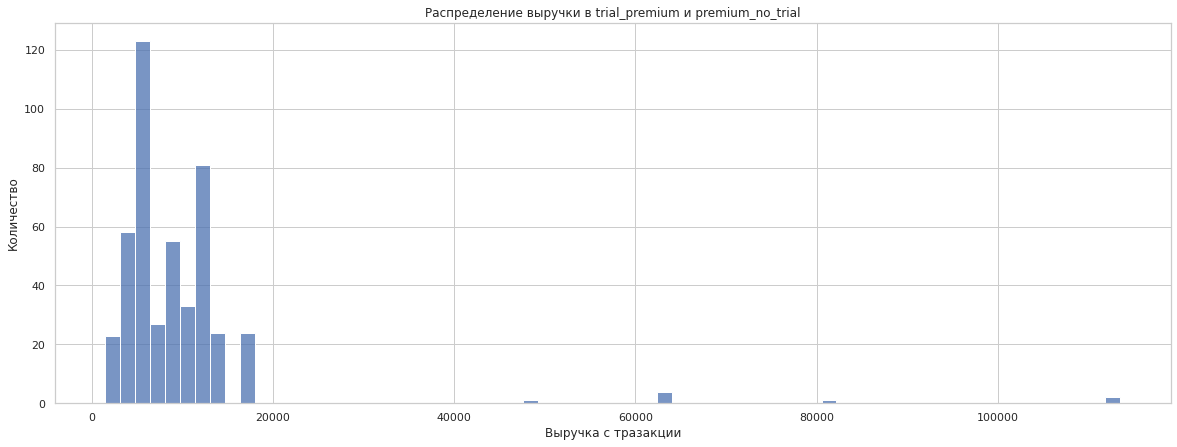

In [51]:
sns.histplot(aov_df.revenue)
plt.title('Распределение выручки в trial_premium и premium_no_trial')
plt.ylabel('Количество')
plt.xlabel('Выручка с тразакции')

Наблюдаются выбросы, которые были видны и на боксплоте, однако само распределение не такое скошенное. Проведу тест на гомогенность дисперсий и сравню группы при помощи множественного дисперсионного анализа. 

In [52]:
p_value = stats.levene(aov_df.query("group == 'test'").revenue, aov_df.query(
    "group == 'control_1'").revenue, aov_df.query("group == 'control_2'").revenue)[1]
print(f"""
H0 – в генеральной совокупности никакого различия между дисперсиями контрольных групп нет. 
H1 – дисперсии контрольных групп не равны в генеральной совокупности. 
P-value: {p_value}.
""")


H0 – в генеральной совокупности никакого различия между дисперсиями контрольных групп нет. 
H1 – дисперсии контрольных групп не равны в генеральной совокупности. 
P-value: 0.5329292201753082.



P-value > 0.05, не отвергаем нулевую гипотезу о том, что в генеральной совокупности никакого различия между дисперсиями контрольных групп нет. Перехожу к множесственному дисперсионному анализу.

In [53]:
stats.f_oneway(aov_df.query("group == 'test'").revenue, aov_df.query(
    "group == 'control_1'").revenue, aov_df.query("group == 'control_2'").revenue)

F_onewayResult(statistic=3.8176840759048245, pvalue=0.022689175050630086)

H0 – ни один из aov не отличается от другого 

H1 – хотя бы один aov отличается от других (есть различия как минимум между двумя группами)

pvalue=0.02. У нас есть основания отклонить H0 и принять альтернативную гипотезу о том, что, как минимум, между двумя группами есть стат. значимое различие. 

Теперь проведу попарное сравнение при помощи критерия Тьюки для определения между какими конкретно группами есть статистические различия.

In [54]:
print(pairwise_tukeyhsd(aov_df.revenue, aov_df.group))

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1    group2   meandiff p-adj    lower      upper   reject
----------------------------------------------------------------
control_1 control_2 -285.5446    0.9 -2932.3918 2361.3027  False
control_1      test 2696.3241 0.0529   -26.5203 5419.1685  False
control_2      test 2981.8687 0.0332   187.5963  5776.141   True
----------------------------------------------------------------


H0 – в генеральной совокупности никакого различия между AOV нет.
H1 – AOV в генеральной совокупности не равны.

Близок к порогу уровня значимости оказался p-value между первой контрольной и тестовой группой, однако все же не перешел его => не можем отклонить нулевую гипотезу.

P-value < 0.05 между второй контрольной и тестовой группой, принимаем альтернативную гипотезу о том, что в генеральной совокупности есть стат. значимая разница в среднем чеке транзакции в категориях, связанных с попдисками в исследуемых странах.

In [55]:
aov_groupped = aov_df.groupby("group", as_index = False) \
                     .agg(aov = ('revenue', 'mean'))
aov_groupped.style.set_caption("AOV по группам в категориях с подписками")

,group,aov
0,control_1,9056.153846
1,control_2,8770.609272
2,test,11752.477941


Средний чек во второй контрольной группой в нашем эксперименте стат. значимо увеличился.


Теперь перехожу к рассмотрению retention.

In [56]:
# Распарсю visit_days
# Оставлю только премиум пользователей

new_users = list(transactions.uid.unique())
retention = users.query("uid in @new_users")

retention['visit_days'] = retention['visit_days'].fillna(0)

retention['visit_days'] = retention['visit_days'].apply(
    lambda x: '[' + str(x) + ']')
retention['visit_days'] = retention['visit_days'].apply(literal_eval)

retention = retention.explode('visit_days')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [57]:
# Буду считать retention 7 дня.
# Проставляю маркер ретеншона

retention['retention'] = np.where(retention['visit_days'] == 7, 1, 0)

In [58]:
retention_seven = retention.groupby(['uid', 'Group', 'is_premium', 'country'], as_index=False) \
                           .agg({'retention': 'sum'}) \
                           .sort_values('retention', ascending=False)

In [59]:
retention_control_1 = round(retention_seven.query(
    "Group == 'control_1'").retention.mean() * 100, 2)
retention_control_2 = round(retention_seven.query(
    "Group == 'control_2'").retention.mean() * 100, 2)
retention_test = round(retention_seven.query(
    "Group == 'test'").retention.mean() * 100, 2)

print(f"""
Retention 7 дня в 1 контрольной группе равен {retention_control_1} %
Retention 7 дня во 2 контрольной группе равен {retention_control_2} %
Retention 7 дня в тестовой группе равен {retention_test} %
        """
      )


Retention 7 дня в 1 контрольной группе равен 49.34 %
Retention 7 дня во 2 контрольной группе равен 56.03 %
Retention 7 дня в тестовой группе равен 52.07 %
        


In [60]:
retention = [retention_control_1, retention_control_2, retention_test]
stats.chisquare(f_obs=retention)

Power_divergenceResult(statistic=0.431215701219512, pvalue=0.8060513324423549)

H0 - Нет статистически значимой разницы в уровне удержания между группами.

H1 - Существует статистически значимая разница в уровне удержания между группами.

P-value > 0.05 (0.8), следовательно у нас нет оснований отклонить нулевую гипотезу, делаю вывод, что нас эксперимент не показал стат. значимое различие в retention по странам. 

Теперь перейду к расчету конверсии в подписчика.

In [61]:
# Заполняю нулями пропущенные значения
users['was_premium'] = users['was_premium'].fillna(0)
users['is_premium'] = users['was_premium'].fillna(0)

# создаю датафрейм для расчета конверсии
conversion_df = users

In [62]:
# Для начала беру количество уникальных пользователей по группам
# У каждой строчки уникальный пользователь, дубликатов нет
users_control1 = conversion_df.query("Group == 'control_1'").uid.nunique()
users_control2 = conversion_df.query("Group == 'control_2'").uid.nunique()
users_test = conversion_df.query("Group == 'test'").uid.nunique()

# Беру количество платных подписчиков.
# Пользователей, которые когда-то были подписчиками тоже буду считать сконевртированными 
prems_control1 = conversion_df.query(
    "Group == 'control_1' and (is_premium == 1 or was_premium ==1)").shape[0]
prems_control2 = conversion_df.query(
    "Group == 'control_2' and (is_premium == 1 or was_premium == 1)").shape[0]
prems_test = conversion_df.query(
    "Group == 'test' and (is_premium == 1 or was_premium == 1)").shape[0]

# Считаю конверсию в подписчика
cr_control1 = prems_control1 / users_control1
cr_control2 = prems_control2 / users_control2
cr_test = prems_test / users_test

conversion = pd.DataFrame(
    {'control_1': cr_control1, 'control_2': cr_control2, 'test': cr_test}, index=[0])
conversion = conversion.style.set_caption("Конверсия из пользователя в подписчика")
conversion

,control_1,control_2,test
0,0.101456,0.096829,0.096089


In [63]:
conversion = [cr_control1, cr_control2, cr_test]

In [64]:
stats.chisquare(f_obs=conversion)

Power_divergenceResult(statistic=0.00017245087618674424, pvalue=0.9999137782792129)

H0 - Нет статистически значимой разницы в уровне удержания между группами.

H1 - Существует статистически значимая разница в уровне удержания между группами.

P-value > 0.05 (0.99), следовательно у нас нет оснований отклонить нулевую гипотезу, делаю вывод, что нас эксперимент не показал стат. значимое различие в конверсию в подписчика по странам. 

Последняя метрика, которую я хотел проверить - количество пользователей в платежных системах 0, 68, 147 в исследумеых странах. Использовать буду таблицы сопряженности. 

In [65]:
payment_systems = transactions.query("payment_id in (0, 68, 147)")

In [66]:
payment_cross = pd.crosstab(payment_systems.payment_id, payment_systems.group)

In [67]:
res = chi2_contingency(payment_cross[['control_1', 'control_2', 'test']])
res

(1.455230289110335,
 0.8345411582465603,
 4,
 array([[  1.48695652,   1.31304348,   1.2       ],
        [ 15.98478261,  14.11521739,  12.9       ],
        [153.52826087, 135.57173913, 123.9       ]]))

H0 - Нет статистически значимой связи между группами пользователей и выбором платежных систем.

H1 - Существует статистически значимая связь между группами пользователей и выбором платежных систем.

P-value > 0.05 (0.83), у нас нет оснований отклонять нулевую гипотезу => делаем вывод, что в нашем эксперименте нет статистически значимой связи между группами пользователей и выбором платежных систем.

# Вывод

Мною было обнаружено несколько проблем в организации эксперимента: 
1. В датафрейм первой контрольной группы попало больше половины Null значений;
2. отсутствует точность, как минимум, до секунд в колонка со временем;
3. отсутствие информации о регистрации в таблицах users.

Для оценки результатов эксперимента выбрал следующие метрики:

1. AOV в категориях 'trial_premium' и 'premium_no_trial' среди новых пользователей. Ожидаюлось, что AOV в тестовой группе должен быть стат. значимо больше;
2. конверсия в подписчика. Ожидалось, что среди в тестовой группе конверсия должна стат.значимо повыситься;
3. retention среди новых пользователей. Прокси метрика от которой ожидалось стат. значимое повышение в тестовой группе. Моя гипотеза заключалась в том, что изменение цены должно привести к повышения конверсии, а платные пользователи пользуются и возвращаются в приложение чаще обычных;
4. количество пользователей в платежных системах 0, 68, 147. Ожидалось, что их количество должно стат. значимо различаться, поскольку изменение, предположительно, произошло в двух из этих систем.

Пришел к следующим выводам:

У нас есть основания предположить, что в тестовой группе стат. значимо увеличился средний чек по сравнению со второй контрольной группой в категориях 'trial_premium' и 'premium_no_trial'. 

Стат. значимых различий в конверсии и удержании (7 дня) мною обнаружено не было, также не было обнаружено стат. значимых различий в количестве пользователей платежных систем 0, 68, 147. 

В целом, считаю, что эксперимент скорее неудачный, чем удачный, поскольку кроме AOV стат. значимо не увеличилось ничего (хоть это и хорошо). Ожидалось, что из-за изменения цены повысится конверсия в подписчика (percentage of users who are paid - North Star Metric тиндера. Источник: https://future.com/north-star-metrics/), количество пользователей в платежных системах также стат. значимо не увиличилось (хотя кажется, что изменение цены должно быть драйверов к использованию именно этих систем), прокси метрика ретеншона тоже стат. значимо не увеличилась.

В работе были использованы следующие статистические тесты:

1. Дисперсионный анализ;
2. множественный дисперсионный анализ;
3. критерий Тьюки;
4. хи-квадрат;
5. таблицы сопряженности;
6. t-test.